In [1]:
import argparse
import click
import itertools
import librosa
import numpy as np
import os
import sys
import time

_EPS = 1e-14

def simpleab(seq_a, seq_b, subseq_len):
    
    # prerequisites
    ndim = seq_b.shape[0]    
    seq_a_len = seq_a.shape[1]
    seq_b_len = seq_b.shape[1]
    
    matrix_profile_len = seq_a_len - subseq_len + 1;
    
    # the "inverted" dot products will be used as the first value for reusing the dot products
    prods_inv = np.full([ndim,seq_a.shape[1]+subseq_len-1], np.inf)
    first_subseq = np.flip(seq_b[:,0:subseq_len],1)  
    for i_dim in range(0,ndim):
        prods_inv[i_dim,:] = np.convolve(first_subseq[i_dim,:],seq_a[i_dim,:])
    prods_inv = prods_inv[:, subseq_len-1:seq_a.shape[1]]
       
    # windowed cumulative sum of the sequence b
    seq_b_cum_sum2 = np.insert(np.sum(np.cumsum(np.square(seq_b),1),0), 0, 0)
    seq_b_cum_sum2 = seq_b_cum_sum2[subseq_len:]-seq_b_cum_sum2[0:seq_b_len - subseq_len + 1]
    
    subseq_cum_sum2 = np.sum(np.square(seq_a[:,0:subseq_len]))
    
    # first distance profile
    first_subseq = np.flip(seq_a[:,0:subseq_len],1)
    dist_profile = seq_b_cum_sum2 + subseq_cum_sum2
    
    prods = np.full([ndim,seq_b_len+subseq_len-1], np.inf)
    for i_dim in range(0,ndim):
        prods[i_dim,:] = np.convolve(first_subseq[i_dim,:],seq_b[i_dim,:])
        dist_profile -= (2 * prods[i_dim,subseq_len-1:seq_b_len])
    prods = prods[:, subseq_len-1:seq_b_len] # only the interesting products
        
    matrix_profile = np.full(matrix_profile_len, np.inf)
    matrix_profile[0] = np.min(dist_profile)

    mp_index = -np.ones((matrix_profile_len), dtype=int)
    mp_index[0] = np.argmin(dist_profile)

    # for all the other values of the profile
    for i_subseq in range(1,matrix_profile_len):
        
        sub_value = seq_a[:,i_subseq-1, np.newaxis] * seq_b[:,0:prods.shape[1]-1]
        add_value = seq_a[:,i_subseq+subseq_len-1, np.newaxis] * seq_b[:, subseq_len:subseq_len+prods.shape[1]-1]
        
        prods[:,1:] = prods[:,0:prods.shape[1]-1] - sub_value + add_value
        prods[:,0] = prods_inv[:,i_subseq]
        
        subseq_cum_sum2 += -np.sum(np.square(seq_a[:,i_subseq-1])) + np.sum(np.square(seq_a[:,i_subseq+subseq_len-1]))
        dist_profile = seq_b_cum_sum2 + subseq_cum_sum2 - 2 * np.sum(prods,0)
        
        matrix_profile[i_subseq] = np.min(dist_profile)
        mp_index[i_subseq] = np.argmin(dist_profile)
        
    return matrix_profile, mp_index


def simpleself(seq, subseq_len):
    
    # prerequisites
    exclusion_zone = int(np.round(subseq_len/2));
    ndim = seq.shape[0]
    seq_len = seq.shape[1]
    matrix_profile_len = seq_len - subseq_len + 1;
    
    # windowed cumulative sum of the sequence
    seq_cum_sum2 = np.insert(np.sum(np.cumsum(np.square(seq),1),0), 0, 0)
    seq_cum_sum2 = seq_cum_sum2[subseq_len:]-seq_cum_sum2[0:seq_len - subseq_len + 1]
    
    # first distance profile
    first_subseq = np.flip(seq[:,0:subseq_len],1)    
    dist_profile = seq_cum_sum2 + seq_cum_sum2[0]
    
    prods = np.full([ndim,seq_len+subseq_len-1], np.inf)
    for i_dim in range(0,ndim):
        prods[i_dim,:] = np.convolve(first_subseq[i_dim,:],seq[i_dim,:])
        dist_profile -= (2 * prods[i_dim,subseq_len-1:seq_len])
    prods = prods[:, subseq_len-1:seq_len] # only the interesting products
    prods_inv = np.copy(prods)
    
    dist_profile[0:exclusion_zone] = np.inf
    
    matrix_profile = np.ndarray((matrix_profile_len,matrix_profile_len))
    matrix_profile[0] = dist_profile[:]

    mp_index = -np.ones((matrix_profile_len), dtype=int)
    mp_index[0] = np.argmin(dist_profile)

    # for all the other values of the profile
    for i_subseq in range(1,matrix_profile_len):
        
        sub_value = seq[:,i_subseq-1, np.newaxis] * seq[:,0:prods.shape[1]-1]
        add_value = seq[:,i_subseq+subseq_len-1, np.newaxis] * seq[:, subseq_len:subseq_len+prods.shape[1]-1]

        prods[:,1:] = prods[:,0:prods.shape[1]-1] - sub_value + add_value
        prods[:,0] = prods_inv[:,i_subseq]
        
        # dist_profile = seq^2 + subseq^2 - 2 * seq.subseq
        subseq_cum_sum2 = seq_cum_sum2[i_subseq]
        dist_profile = seq_cum_sum2 + subseq_cum_sum2 - 2 * np.sum(prods,0)
        
        # excluding trivial matches
        dist_profile[max(0,i_subseq-exclusion_zone+1):min(matrix_profile_len,i_subseq+exclusion_zone)] = np.inf
        
        matrix_profile[i_subseq] = dist_profile[:]
        mp_index[i_subseq] = np.argmin(dist_profile)
        
    return matrix_profile, mp_index


y, sr = librosa.load('Simple/a.mp3')
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

sim_matrix, mpindex = simpleself(chroma_cens, 215) # 215 ~ 5sec

/home/martin/.local/lib/python3.8/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/martin/.local/lib/python3.8/site-packages/librosa/util/utils.py:991: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return (x > x_pad[inds1]) & (x >= x_pad[inds2])
/home/martin/.local/lib/python3.8/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.

In [2]:
sim_matrix

array([[        inf,         inf,         inf, ..., 80.27777365,
        81.15403673, 82.04709994],
       [        inf,         inf,         inf, ..., 80.36670536,
        81.22807417, 82.10568593],
       [        inf,         inf,         inf, ..., 80.46847222,
        81.31556806, 82.17827135],
       ...,
       [80.27777365, 80.36670536, 80.46847222, ...,         inf,
                inf,         inf],
       [81.15403673, 81.22807417, 81.31556806, ...,         inf,
                inf,         inf],
       [82.04709994, 82.10568593, 82.17827135, ...,         inf,
                inf,         inf]])

In [3]:
num_row, num_col = np.shape(sim_matrix)

In [4]:
mediana = 25 #testando valores

In [5]:
exclusion_zone = 25

In [6]:
import time

In [8]:
# As maiores diagonais parecem mudar dependendo do valor da zona de exclusão (o que faz sentido)
time_s = time.time()
diagonal = [None]*num_row
for row in range(num_row):
    tam_max=0
    for col in range(row,num_col):
        if sim_matrix[row][col]<mediana:
            inicio = [row,col]
            tamanho = 0
            while sim_matrix[row+tamanho][col+tamanho]<mediana:
                tamanho+=1
            if tamanho>tam_max:
                diagonal[row] = [inicio,tamanho]
                tam_max = tamanho
    if(tam_max!=0):
        linha,coluna = diagonal[row][0]
        for t in range(tam_max):
                sim_matrix[linha+t][coluna+t-exclusion_zone:coluna+t+exclusion_zone]= np.inf
print("---- %s seconds ----" % (time.time()-time_s))

---- 34.37782526016235 seconds ----


In [11]:
import matplotlib.pyplot as plt

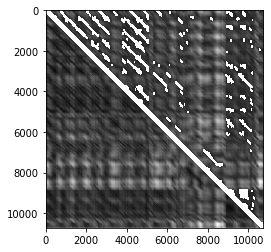

In [12]:
plt.imshow(sim_matrix, 'gray')

In [13]:
diagonal_2 = [x for x in diagonal if x!=None]
diagonal_2
diagonal_2.sort(key=lambda x:x[1],reverse=True)

In [14]:
diagonal_2

[[[548, 4010], 1027],
 [[390, 1037], 1003],
 [[1948, 4118], 926],
 [[1041, 3849], 898],
 [[268, 4373], 667],
 [[2508, 4030], 627],
 [[3161, 9482], 624],
 [[3120, 5308], 617],
 [[3771, 4442], 598],
 [[3845, 4490], 557],
 [[1396, 4229], 547],
 [[5, 2586], 525],
 [[5406, 9551], 519],
 [[815, 4302], 474],
 [[6893, 7752], 462],
 [[719, 2653], 458],
 [[867, 1479], 437],
 [[8858, 9528], 412],
 [[325, 1612], 407],
 [[567, 4646], 389],
 [[1520, 4378], 387],
 [[1506, 4391], 382],
 [[5384, 8866], 370],
 [[3198, 8856], 362],
 [[1491, 2784], 360],
 [[434, 1746], 351],
 [[8914, 9558], 351],
 [[192, 2747], 347],
 [[1594, 2244], 344],
 [[1607, 3788], 341],
 [[3290, 5452], 337],
 [[3556, 6386], 328],
 [[2150, 2797], 327],
 [[8893, 9588], 326],
 [[2787, 4334], 322],
 [[182, 2788], 318],
 [[760, 2046], 304],
 [[2560, 4755], 292],
 [[8866, 9639], 292],
 [[8876, 9621], 290],
 [[1497, 2826], 288],
 [[2283, 4489], 277],
 [[9, 4768], 274],
 [[9541, 9649], 273],
 [[6, 5414], 267],
 [[368, 2302], 267],
 [[1606,

In [15]:
imagem_diag = np.full((num_row,num_col), 255)

In [18]:
for k in range(len(diagonal_2)):
    x,y = diagonal_2[k][0]
    for i in range(diagonal_2[k][1]):
        imagem_diag[x+i][y+i] = 0

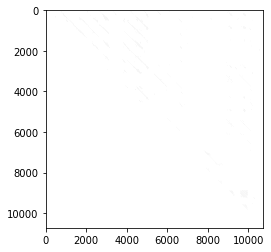

In [19]:
plt.imshow(imagem_diag, 'gray') # As diagonais tão muito apagadas e eu n to entendendo o pq deus me ajud 